In [1]:
library('igraph')
library('xts')


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



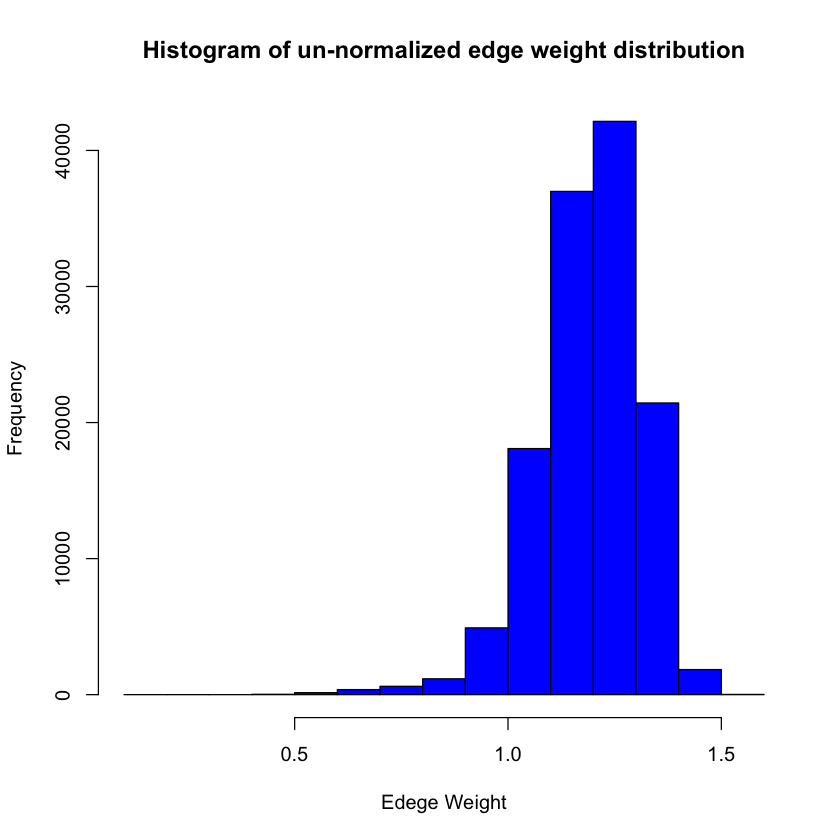

In [2]:
library(igraph)
library(xts)
setwd("/Users/linzuoli/workspace/ECE232_Graph/Project_5/data/")

# Question 1

get_time_series_from_stock_info = function(csv_name) {
  # Get the stock info from a csv file
  stock_info = read.csv(paste("data", csv_name, sep="/"), header=TRUE, sep=",")
  # Convert into a time series
  
  # 2 of the csv files are mis-formatted: "BF.B.csv", "BRK.B.csv"
  if (csv_name == "BF.B.csv" || csv_name == "BRK.B.csv")
    return(xts(stock_info[,-1], order.by = as.Date(stock_info$Date, format="%m/%d/%y")) )
  return(xts(stock_info[,-1], order.by = as.Date(stock_info$Date)))
}

# Computes r_i(t)
# log(b/a) = log(b)-log(a)
r_t = function(time_series) {
  closing_prices = time_series$Close
  shifted_closing_prices = lag(time_series$Close, 1)
  return((log(closing_prices) - log(shifted_closing_prices))[-1])
}

# Computes the cross correlation coefficient
cross_correlation_coefficient = function(time_series1, time_series2) {
  r1_t = r_t(time_series1)
  r2_t = r_t(time_series2)
  
  top = mean(r1_t * r2_t) - mean(r1_t) * mean(r2_t)
  bot = (mean(r1_t^2) - mean(r1_t)^2) * (mean(r2_t^2) - mean(r2_t)^2)
  return(top / sqrt(bot))
}


# Question 2

# Get all the file csv names
all_csv_file_names = list.files(paste("data", sep="/"), pattern="*.csv")
all_time_series = list()

# Getting all time series from list of csv files so that we can only compute it once
for (csv_file_name in all_csv_file_names) {
  all_time_series[[csv_file_name]] = get_time_series_from_stock_info(csv_file_name)
}

# Creating a cross correlation coefficient matrix
cross_correlation_coefficient_matrix = matrix(0, nrow = length(all_csv_file_names), ncol = length(all_csv_file_names))
i = 1
for (csv_file_name1 in all_csv_file_names) {
  j = 1
  for (csv_file_name2 in all_csv_file_names) {
    if (csv_file_name1 != csv_file_name2) {
      time_series1 = all_time_series[[csv_file_name1]]
      time_series2 = all_time_series[[csv_file_name2]]
      cross_correlation_coefficient_matrix[i, j] = cross_correlation_coefficient(time_series1, time_series2)
    }
    j = j+1
  }
  i = i+1
}

# Computing D
D = sqrt(2 * (1 - cross_correlation_coefficient_matrix))

# Constructing a correlation graph
G = graph_from_adjacency_matrix(D, weighted=TRUE, mode="undirected")

hist(E(G)$weight, main = "Histogram of un-normalized edge weight distribution", xlab = "Edege Weight", col="blue")

# Question 3
spanning_tree = mst(G, weights = E(G)$weight)
all_sectors = read.csv("Name_sector.csv")
symbol_to_sector = list()
for (index in 1:length(all_sectors$Symbol)) {
  symbol_to_sector[[all_sectors$Symbol[index]]] = all_sectors$Sector[index]
}
unique_sectors = unique(read.csv("Name_sector.csv")$Sector)
color_per_sector = list()
i = 1

for (sector in unique_sectors) {
  color_per_sector[[sector]] = i
  i = i + 1
}

V(G)$symbol = all_sectors$Symbol
V(spanning_tree)$symbol = all_sectors$Symbol
V(spanning_tree)$color = unlist(lapply(V(spanning_tree)$symbol, function(x) {color_per_sector[[symbol_to_sector[[x]]]]}))

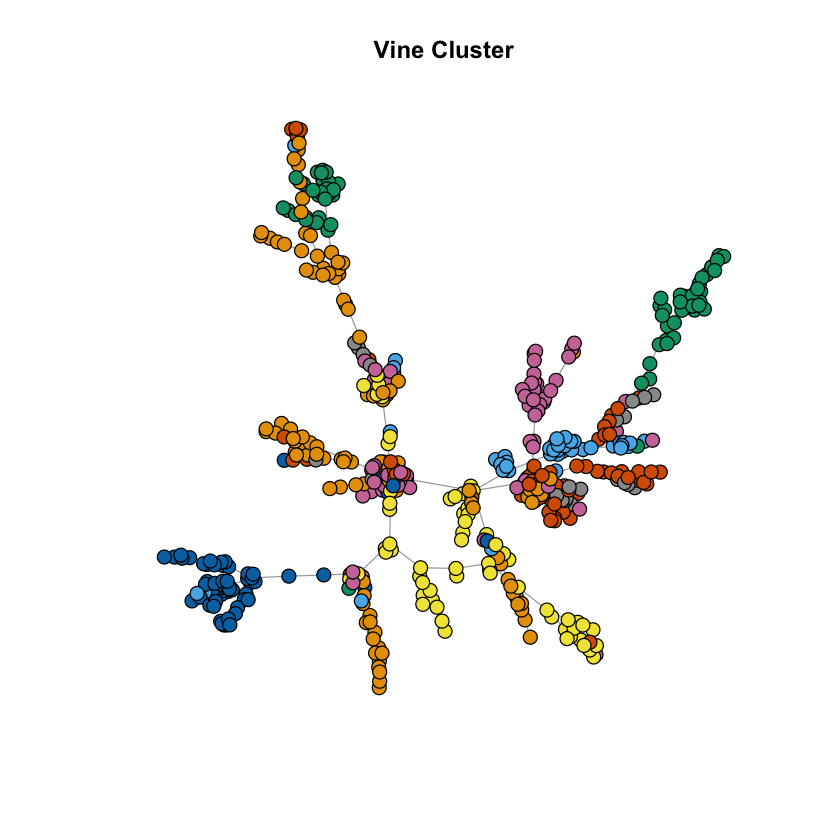

In [3]:
#Q3
plot(spanning_tree, vertex.size = 5, edge.arrow.size=0, vertex.color = V(spanning_tree)$color, vertex.label=NA, main='Vine Cluster')

In [4]:
# Q4
P = 0
for (vertex in V(spanning_tree)) {
  neighbors_of_vertex = neighbors(spanning_tree, vertex)
  v_sector = V(spanning_tree)[vertex]$color
  Q = 0
  N = length(neighbors_of_vertex)
  for (neighbor in neighbors_of_vertex) {
    if (v_sector == V(spanning_tree)[neighbor]$color) {
      Q = Q + 1
    }
  }
  P = P + (Q / N)
}

alpha_1 = P / vcount(spanning_tree)
alpha_1

[1] 0.8217551

In [5]:
freq_count = table(V(minst)$color)/vcount(spanning_tree)
P = 0
for (vertex in V(spanning_tree)) {
  v_sector = V(spanning_tree)[vertex]$color
  P = P + freq_count[v_sector]
}
alpha_2 = P / vcount(spanning_tree)
alpha_2                   

ERROR: Error in "igraph" %in% class(graph): object 'minst' not found


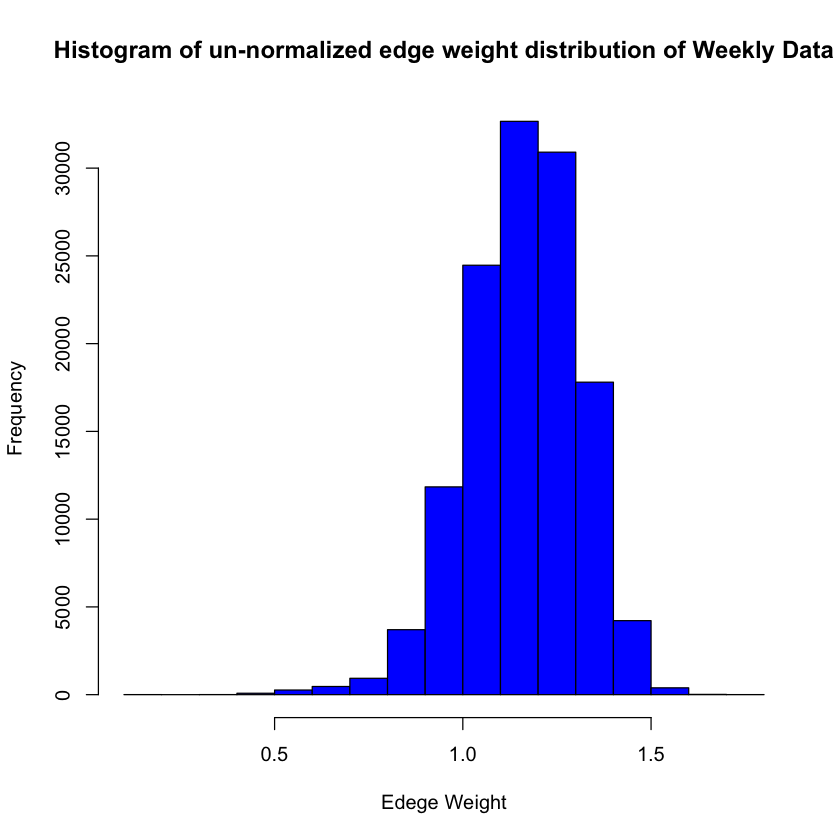

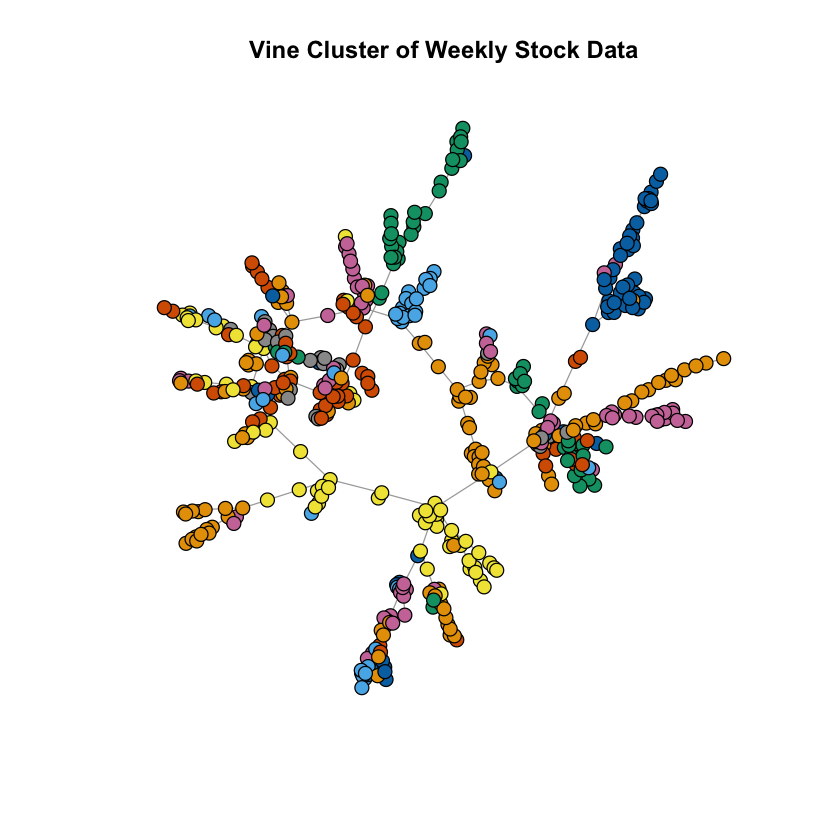

In [11]:
# Q5

# Getting all time series from list of csv files so that we can only compute it once
for (csv_file_name in all_csv_file_names) {
  mondays = weekdays(index(get_time_series_from_stock_info(csv_file_name))) == 'Monday'
  all_time_series[[csv_file_name]] = get_time_series_from_stock_info(csv_file_name)[mondays]
}

# Creating a cross correlation coefficient matrix
cross_correlation_coefficient_matrix = matrix(0, nrow = length(all_csv_file_names), ncol = length(all_csv_file_names))
i = 1
for (csv_file_name1 in all_csv_file_names) {
  j = 1
  for (csv_file_name2 in all_csv_file_names) {
    if (csv_file_name1 != csv_file_name2) {
      time_series1 = all_time_series[[csv_file_name1]]
      time_series2 = all_time_series[[csv_file_name2]]
      cross_correlation_coefficient_matrix[i, j] = cross_correlation_coefficient(time_series1, time_series2)
    }
    j = j+1
  }
  i = i+1
}

# Computing D
D = sqrt(2 * (1 - cross_correlation_coefficient_matrix))

# Constructing a correlation graph
G = graph_from_adjacency_matrix(D, weighted=TRUE, mode="undirected")

hist(E(G)$weight, main = "Histogram of un-normalized edge weight distribution of Weekly Data", xlab = "Edege Weight", col="blue")

# Question 3
spanning_tree = mst(G, weights = E(G)$weight)
all_sectors = read.csv("Name_sector.csv")
symbol_to_sector = list()
for (index in 1:length(all_sectors$Symbol)) {
  symbol_to_sector[[all_sectors$Symbol[index]]] = all_sectors$Sector[index]
}
unique_sectors = unique(read.csv("Name_sector.csv")$Sector)
color_per_sector = list()
i = 1

for (sector in unique_sectors) {
  color_per_sector[[sector]] = i
  i = i + 1
}

V(G)$symbol = all_sectors$Symbol
V(spanning_tree)$symbol = all_sectors$Symbol
V(spanning_tree)$color = unlist(lapply(V(spanning_tree)$symbol, function(x) {color_per_sector[[symbol_to_sector[[x]]]]}))
plot(spanning_tree, vertex.size = 5, edge.arrow.size=0, vertex.color = V(spanning_tree)$color, vertex.label=NA, main='Vine Cluster of Weekly Stock Data')

